In [418]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [419]:
print(torch.cuda.is_available())

True


In [420]:
model_train_loss = []
model_val_loss = []
model_train_acc = []
model_val_acc = []

In [421]:
# Define myModel Class
class myCNN(nn.Module):
    def __init__(self, num_classes):
        super(myCNN, self).__init__()
        # convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding = 2,  stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # fully connected layers
        self.connect = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes),
        )
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.connect(x)
        return x

In [422]:
# Function to plot loss and accuracy
def plot_loss_and_accuracy(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b.-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r.-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b.-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r.-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [423]:
# Define Train_Model Function
def train_model(train_loader, val_loader, epochs , num_classes, batch_size=32, learning_rate=0.001):
    # Device Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Initialize the model
    model = myCNN(num_classes=num_classes).to(device)

    # Define loss function an optimizer
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.MultiMarginLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Change Optimizer - AdaGrad
    #### optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    # Change Optimizer - SGD
    #### optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100*correct / total
        model_train_loss.append(epoch_loss)
        model_train_acc.append(epoch_acc)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        model_val_loss.append(val_epoch_loss)
        model_val_acc.append(val_epoch_acc)
        print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.2f}%")

    return model

In [424]:
# Define the function to evaluate the model
def evaluate(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_epoch_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_epoch_acc:.2f}%")

    return ground_truths, predictions

# Main Function

Epoch [1/100], Loss: 0.6648, Accuracy: 37.45%
Validation Loss: 0.4715, Accuracy: 52.29%
Epoch [2/100], Loss: 0.4794, Accuracy: 50.57%
Validation Loss: 0.4139, Accuracy: 55.62%
Epoch [3/100], Loss: 0.4232, Accuracy: 54.43%
Validation Loss: 0.4137, Accuracy: 54.17%
Epoch [4/100], Loss: 0.3891, Accuracy: 57.86%
Validation Loss: 0.4261, Accuracy: 52.71%
Epoch [5/100], Loss: 0.3740, Accuracy: 58.54%
Validation Loss: 0.3713, Accuracy: 57.92%
Epoch [6/100], Loss: 0.3567, Accuracy: 59.11%
Validation Loss: 0.3642, Accuracy: 57.92%
Epoch [7/100], Loss: 0.3274, Accuracy: 62.45%
Validation Loss: 0.3652, Accuracy: 58.12%
Epoch [8/100], Loss: 0.3181, Accuracy: 63.18%
Validation Loss: 0.3247, Accuracy: 65.00%
Epoch [9/100], Loss: 0.3008, Accuracy: 65.78%
Validation Loss: 0.3166, Accuracy: 64.38%
Epoch [10/100], Loss: 0.2924, Accuracy: 66.51%
Validation Loss: 0.3158, Accuracy: 65.62%
Epoch [11/100], Loss: 0.2821, Accuracy: 67.71%
Validation Loss: 0.3008, Accuracy: 67.08%
Epoch [12/100], Loss: 0.2853, 

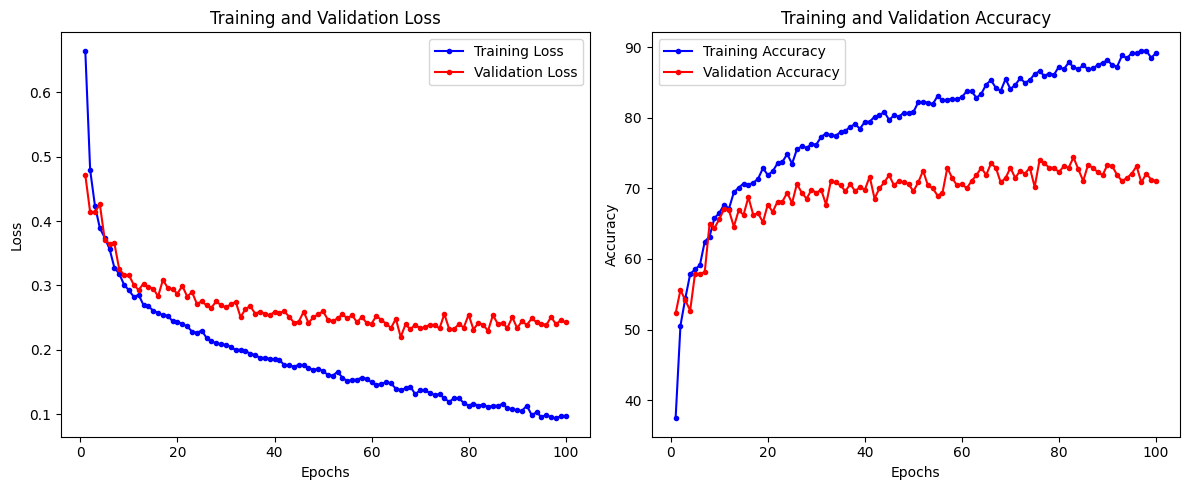

Test Accuracy: 77.17%
[[134, 48, 4], [61, 144, 11], [5, 8, 185]]


In [425]:
if __name__ == "__main__":
    # Define data transformations -- Original
    transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    '''
    # Define data transformations -- Augmentation
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # flip
        transforms.RandomRotation(180),  # rotate
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # crop
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    '''

    # Load dataset
    dataset_path = 'D:\\zc\\Course\\1122\\MCA\\hw5\\dataset\\animals'  # Path to your dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

    # Split dataset into training, validation, and test sets
    train_val_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=np.array(dataset.targets),random_state=0)
    train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, stratify=np.array(dataset.targets)[train_val_indices],random_state=0)

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get number of classes
    num_classes = len(dataset.classes)

    # Train the model
    trained_model = train_model(train_loader, val_loader, epochs=100, num_classes=num_classes)

    # Plot the result
    plot_loss_and_accuracy(model_train_loss, model_val_loss, model_train_acc, model_val_acc)

    # Evaluate the model
    ground, pred = evaluate(trained_model, test_loader)
    mat = [[0,0,0],[0,0,0],[0,0,0]]
    for x in range(len(pred)):
        mat[pred[x]][ground[x]] += 1

    print(mat)